# Credit Card Fraud Detection

# Data Description
### (https://www.kaggle.com/mlg-ulb/creditcardfraud)

Description
Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

# Key findings from the data description
## 1 - The dataset presents transaction that occued over two days
## 2 - There are 492 fraud transaction out of total 284,807 transactions, thus the dataset is extremely imbalanced
## 3 - The variables are derived by PCA transformation - This means the data has already been scaled and no further PCA is needed
## 4 - PCA was not applied on 'Time' and 'Amount' features

In [1]:
!pip install imblearn  

    100% |████████████████████████████████| 163kB 9.0MB/s ta 0:00:01
    100% |████████████████████████████████| 6.9MB 6.8MB/s eta 0:00:01
    100% |████████████████████████████████| 307kB 44.6MB/s ta 0:00:01
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from imblearn.under_sampling import NearMiss
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [3]:
# Opening csv in AWS Sagemaker Jupyter Notebook


bucket='sagemaker-kamran'
data_key = 'creditcard.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Count 0s = 284315
Count 1s = 492
Percentage of fraud transactions = 0.17304750013189596%


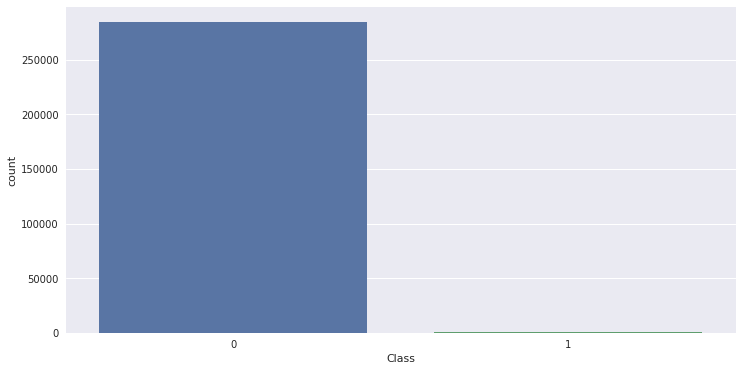

In [6]:
plt.figure(figsize=(12, 6))
sns.countplot(df['Class'])
print('Count 0s = {}'.format((df['Class']==0).sum()))
print('Count 1s = {}'.format((df['Class']==1).sum()))
print('Percentage of fraud transactions = {}%'.format((df['Class']==1).sum() / (df['Class']==0).sum() * 100))

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


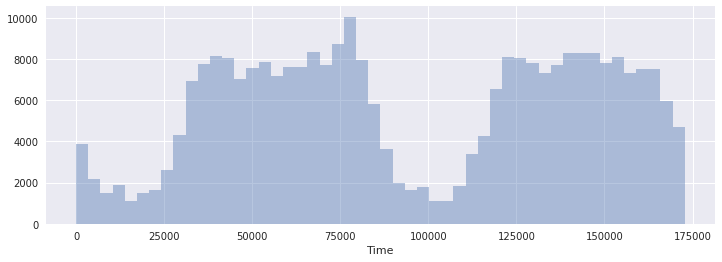

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


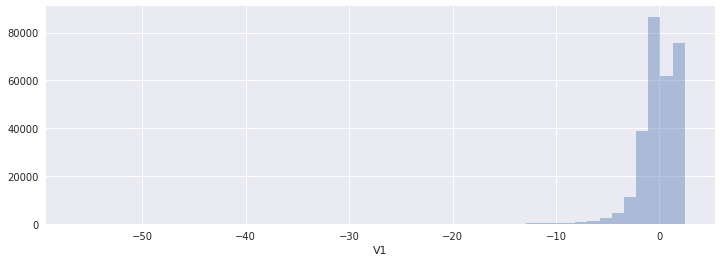

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


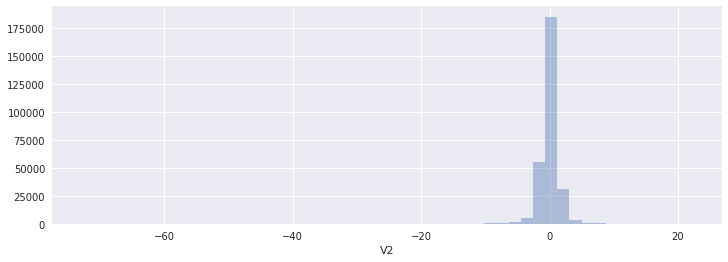

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


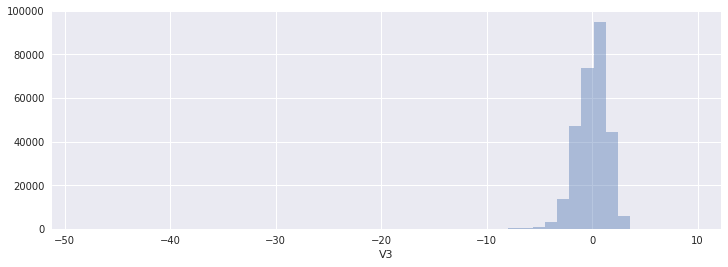

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


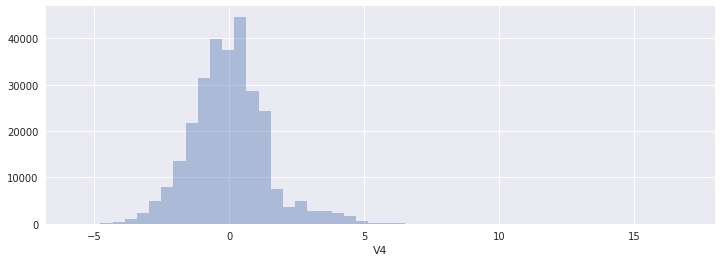

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


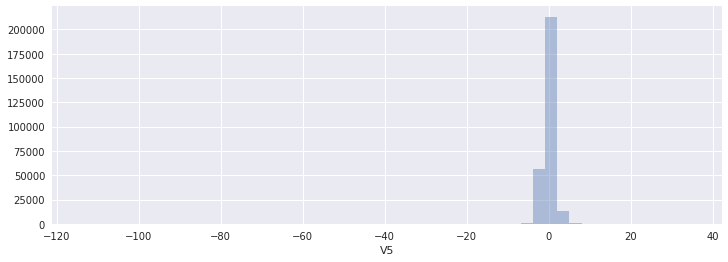

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


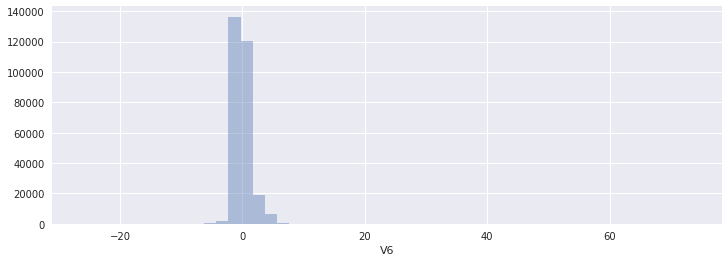

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


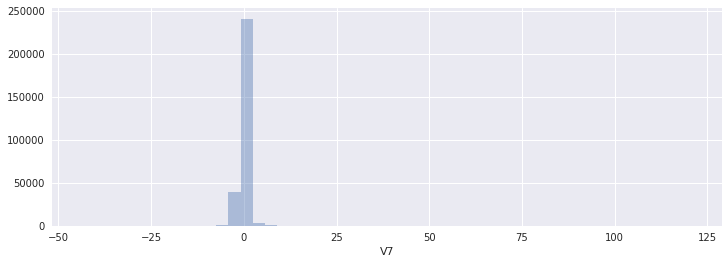

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


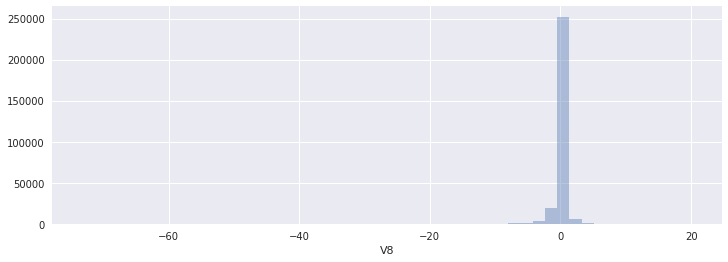

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


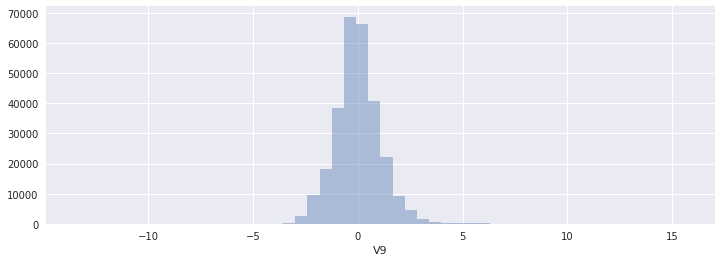

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


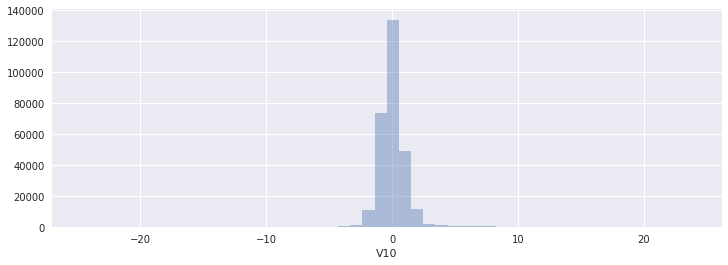

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


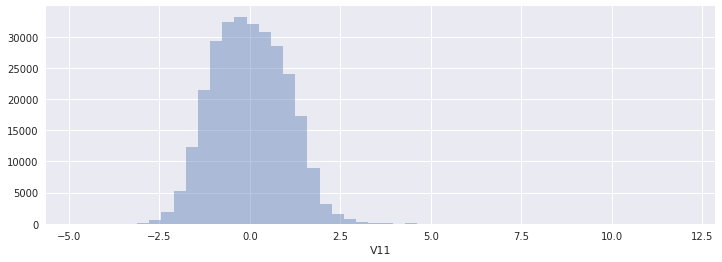

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


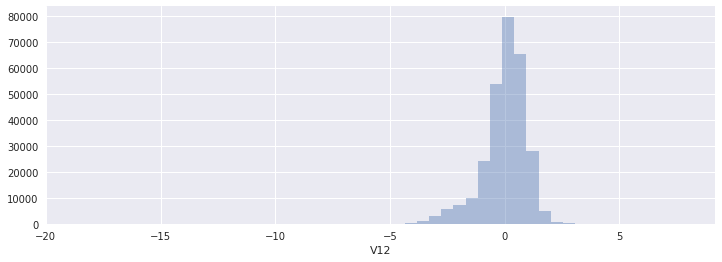

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


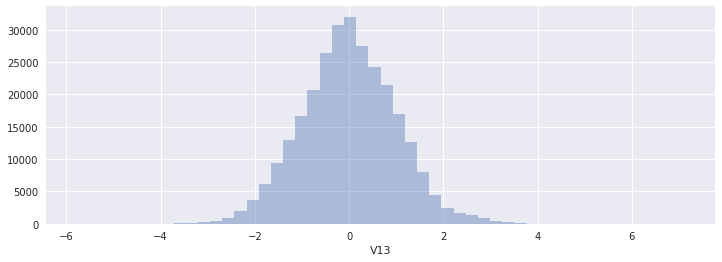

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


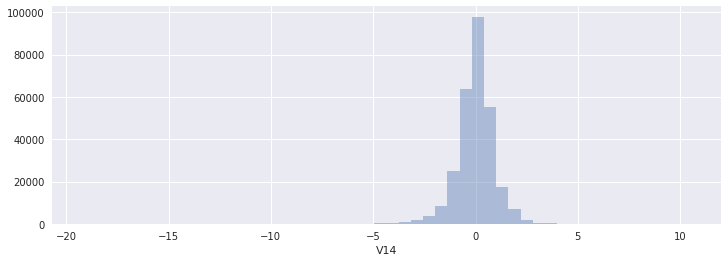

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


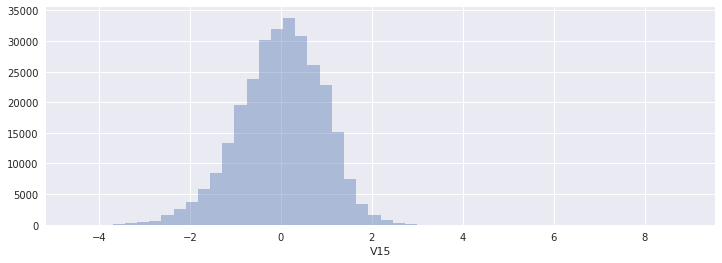

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


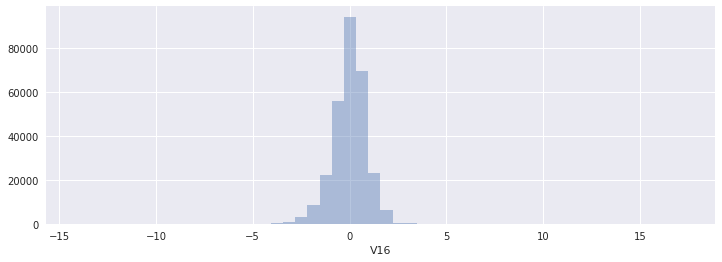

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


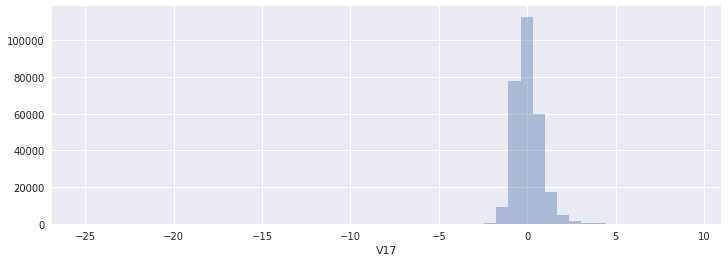

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


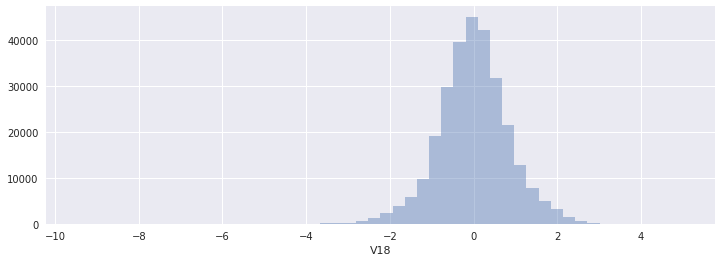

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


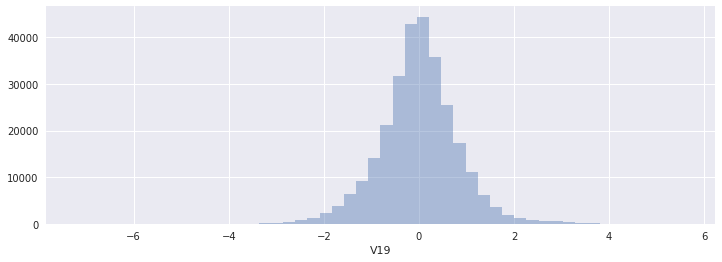

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


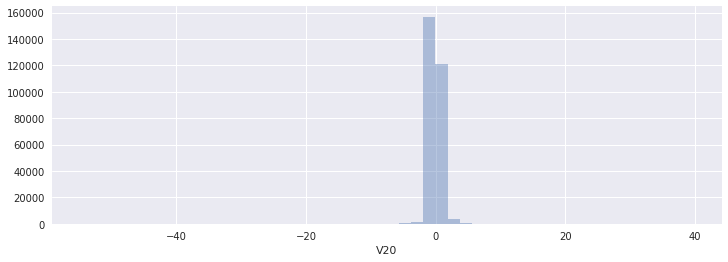

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


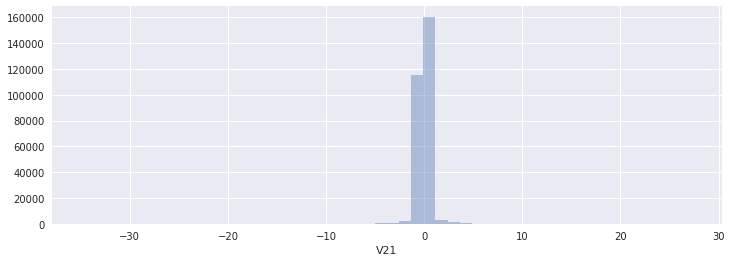

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


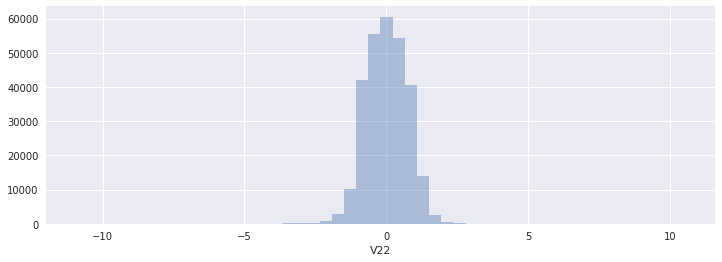

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


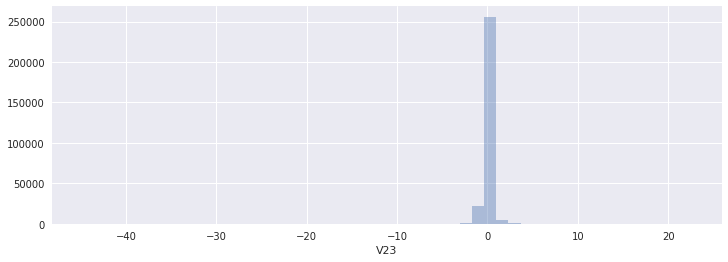

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


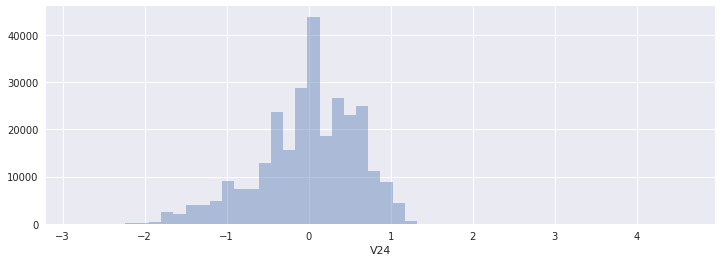

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


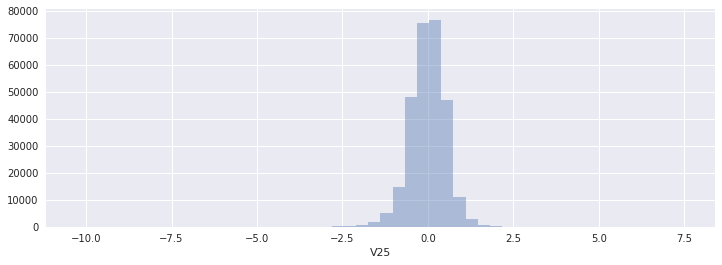

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


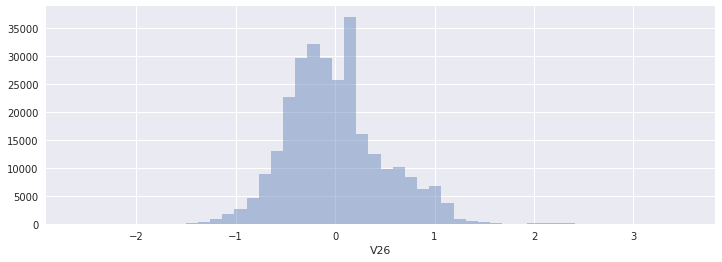

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


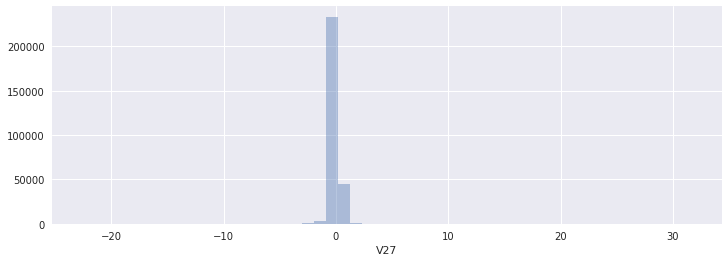

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


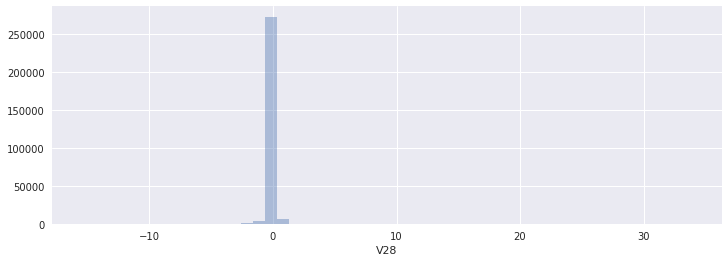

Please scroll down this winndow


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


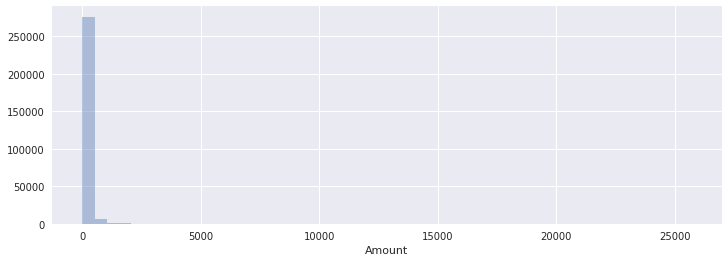

In [7]:
# Each feature visualized

for each in df.drop(columns='Class').columns:
    print('Please scroll down this winndow')
    fig = plt.subplots(figsize=(12, 4))
    sns.distplot(df[each], kde=False)
    plt.show()

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


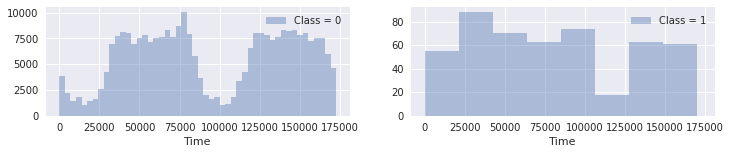

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


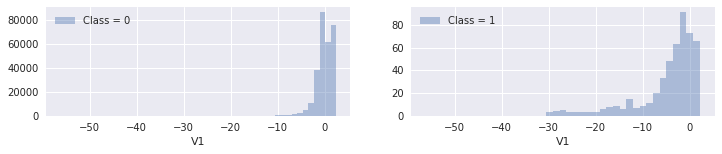

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


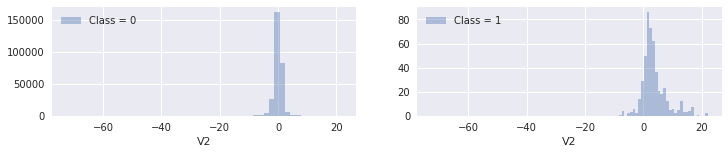

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


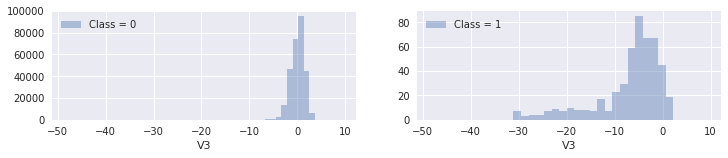

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


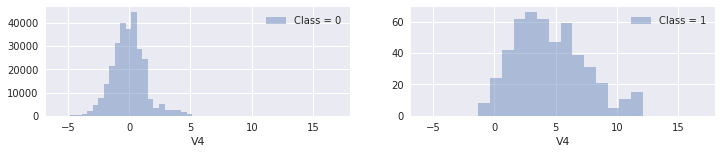

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


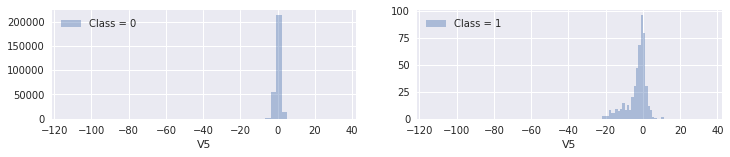

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


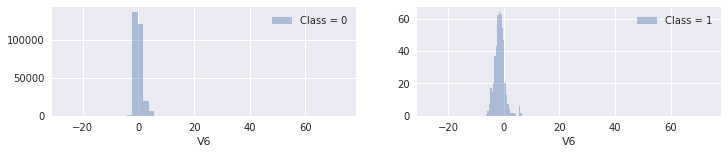

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


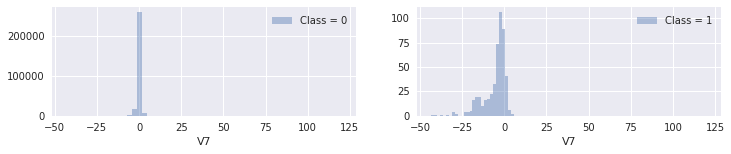

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


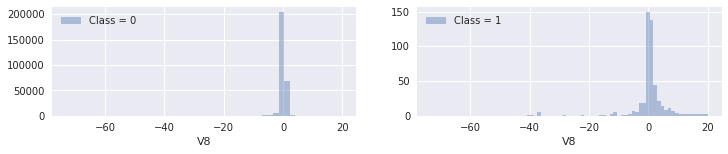

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


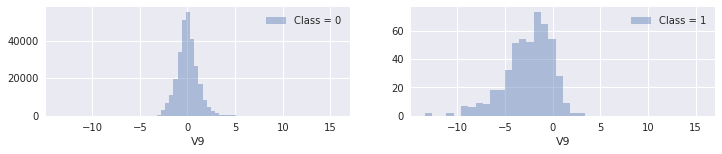

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


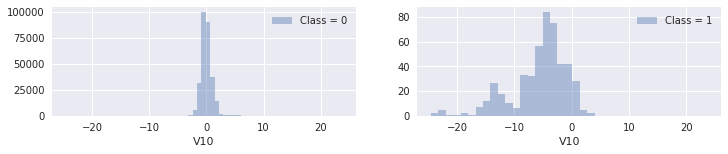

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


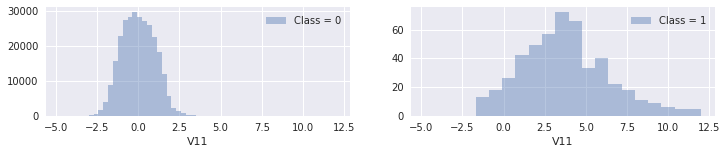

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


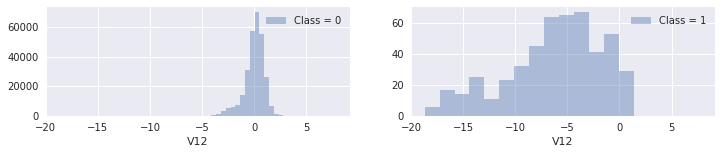

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


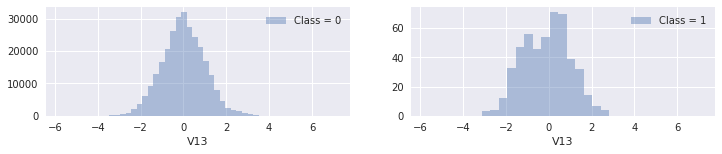

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


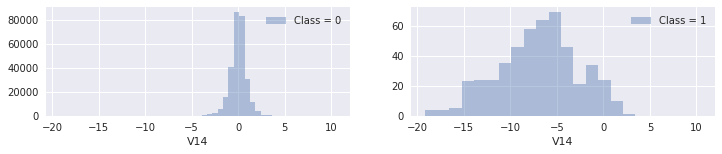

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


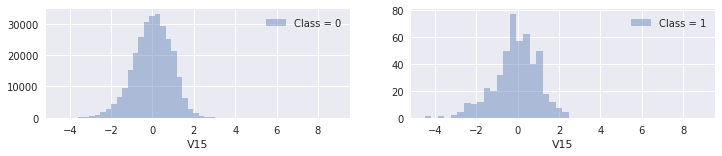

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


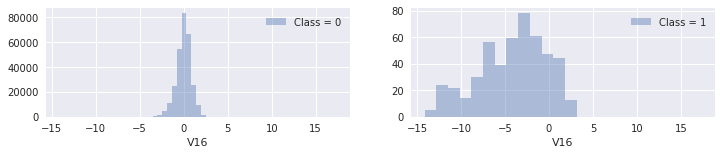

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


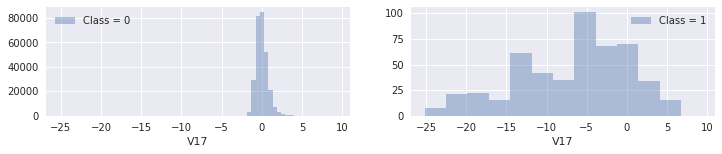

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


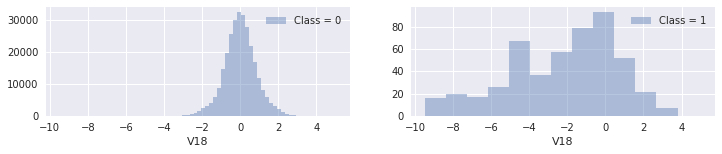

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


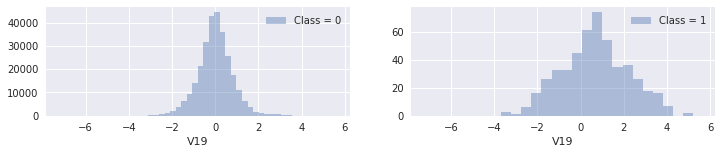

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


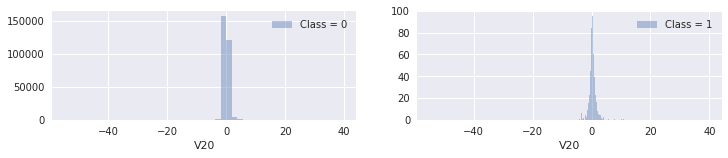

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


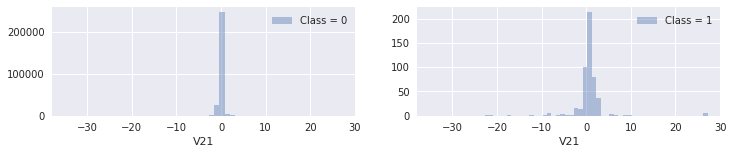

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


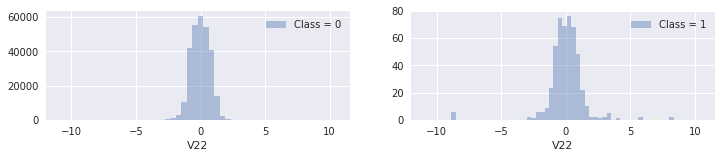

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


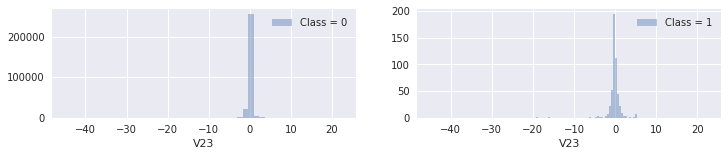

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


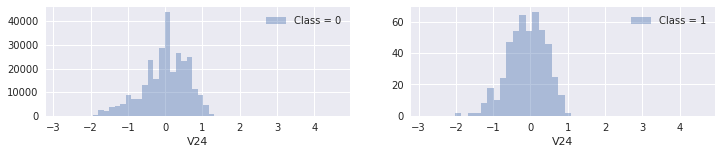

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


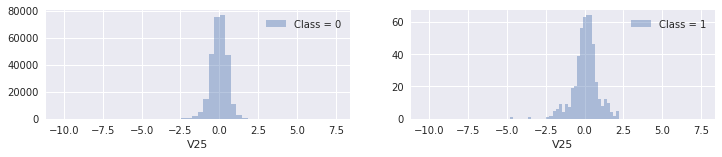

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


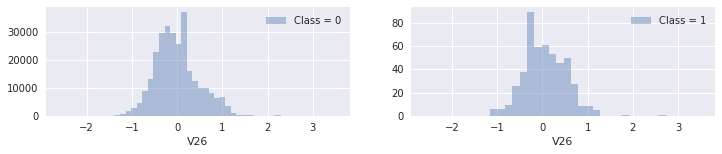

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


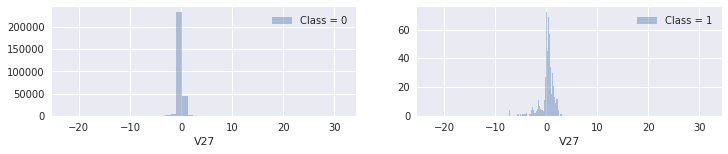

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


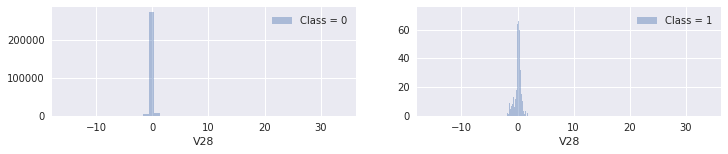

Please scroll down this window


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


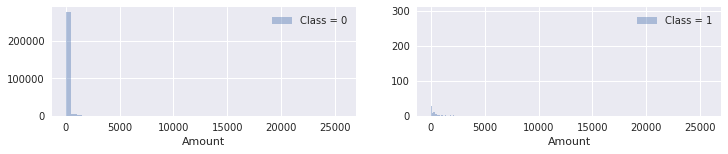

In [8]:
# Each feature visualised by class

df0s = df[df['Class']==0]
df1s = df[df['Class']==1]

for each in df.drop(columns='Class').columns:
    print('Please scroll down this window')
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 2))
    sns.distplot(df0s[each], kde=False, ax=axs[0], label='Class = 0')
    axs[0].legend()
    sns.distplot(df1s[each], kde=False, ax=axs[1], label='Class = 1')
    axs[1].legend()
    plt.show()

In [9]:
X = df.drop(columns='Class').values
y = df['Class'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Undersampling technique
## We will be under sampling (us) only the training data. Once a model is trained, we will test it on the test data, which remains untouched

In [11]:
nm = NearMiss()
X_train_us, y_train_us = nm.fit_resample(X_train, y_train)
print('Shape of X_train is {}, and y_train is {}'.format(X_train.shape, y_train.shape))
print('Shape of UNDERSAMPLED X_train_us is {}, and y_train_us is {}'.format(X_train_us.shape, y_train_us.shape))

Shape of X_train is (190820, 30), and y_train is (190820,)
Shape of UNDERSAMPLED X_train_us is (688, 30), and y_train_us is (688,)


## Models compared

In [12]:
clf_models = []
clf_models.append(('MLPClf', MLPClassifier()))
clf_models.append(('KNN', KNeighborsClassifier()))
clf_models.append(('SVC', SVC()))
clf_models.append(('GausProcess', GaussianProcessClassifier()))
clf_models.append(('DTree', DecisionTreeClassifier()))
clf_models.append(('RandForest', RandomForestClassifier()))
clf_models.append(('AdaBoost', AdaBoostClassifier()))
clf_models.append(('GausNB', GaussianNB()))
clf_models.append(('QuadDiscAna', QuadraticDiscriminantAnalysis()))

results = []
names = []

for name, model in clf_models:
    kfold = KFold(n_splits=5, shuffle=True)
    cv_results = cross_val_score(model, X_train_us, y_train_us, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    note = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(note)

MLPClf: 0.608950 (0.074468)
KNN: 0.908442 (0.018690)
SVC: 0.638136 (0.020805)
GausProcess: 0.595991 (0.026065)
DTree: 0.924458 (0.013259)
RandForest: 0.946208 (0.013508)
AdaBoost: 0.956363 (0.019039)
GausNB: 0.898159 (0.028705)
QuadDiscAna: 0.928742 (0.021432)


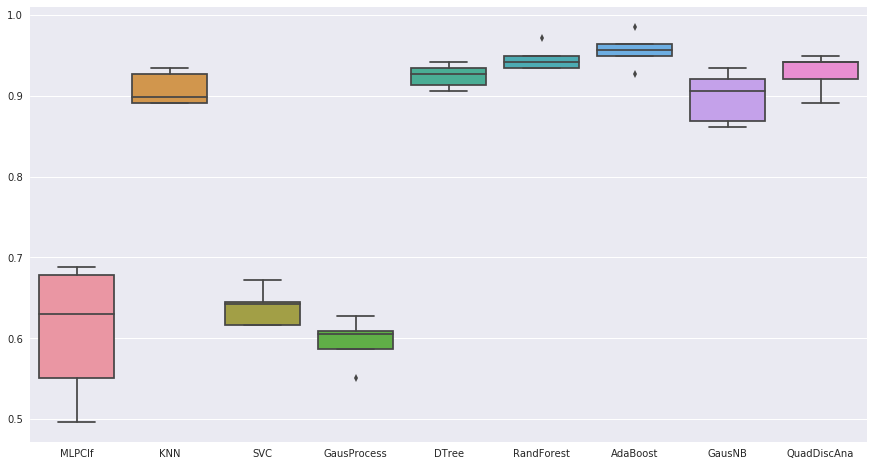

In [13]:
plt.figure(figsize=(15, 8))
sns.boxplot(names, results)

## It looks like AdaBoost, Random Forest and Decision Tree classifiers have performed better than the other models. Now we fine tune these three to see if we can get even better results

### Ada Boost Classifier on under-sampled data

In [14]:
abc = AdaBoostClassifier()

abc_param = {'n_estimators' : [130, 140, 150], 'learning_rate' : [0.5, 1.0]}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

abc_gs = GridSearchCV(abc, param_grid=abc_param, cv=5)

abc_gs.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.5, 1.0],
                         'n_estimators': [130, 140, 150]})

In [15]:
print(abc_gs.best_params_)

{'learning_rate': 1.0, 'n_estimators': 130}


In [16]:
adaboost = AdaBoostClassifier(**abc_gs.best_params_)

adaboost.fit(X_train_us, y_train_us)

AdaBoostClassifier(n_estimators=130)

In [17]:
ada_preds = adaboost.predict(X_test)

Text(33.0, 0.5, 'y-true')

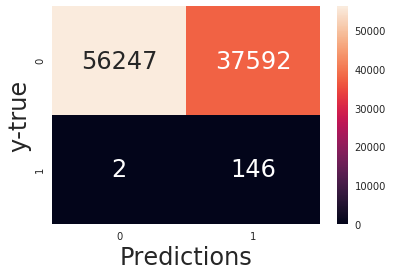

In [18]:
ada_cm = confusion_matrix(y_test, ada_preds)

sns.heatmap(ada_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [19]:
ada_cr = classification_report(y_test, ada_preds)
print('AdaBoostClassifier classification report' '\n', ada_cr)

AdaBoostClassifier classification report
               precision    recall  f1-score   support

           0       1.00      0.60      0.75     93839
           1       0.00      0.99      0.01       148

    accuracy                           0.60     93987
   macro avg       0.50      0.79      0.38     93987
weighted avg       1.00      0.60      0.75     93987



In [20]:
ada_us_metrics = {'Precision' : precision_score(y_test, ada_preds), 'Recall' : recall_score(y_test, ada_preds),
                  'F1 Score' : f1_score(y_test, ada_preds)}
print(ada_us_metrics)

{'Precision': 0.0038687794795696645, 'Recall': 0.9864864864864865, 'F1 Score': 0.007707332523887452}


### Random Forest Classifier on under-sampled data

In [21]:
rf = RandomForestClassifier()

rf_param = {'n_estimators' : [50, 60, 70], 'max_depth' : [None, 30, 40, 50], 
            'min_samples_split' : [40, 45, 50, 55, 60], 'min_samples_leaf' : [1, 2], 
            'max_features' : ['log2']}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

rf_gs = GridSearchCV(estimator=rf, param_grid=rf_param, cv=5, n_jobs=-2)

rf_gs.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [None, 30, 40, 50],
                         'max_features': ['log2'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [40, 45, 50, 55, 60],
                         'n_estimators': [50, 60, 70]})

In [22]:
rf_gs.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 60,
 'n_estimators': 50}

In [23]:
rf_clf = RandomForestClassifier(**rf_gs.best_params_)

rf_clf.fit(X_train_us, y_train_us)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=60, n_estimators=50)

In [24]:
rf_preds = rf_clf.predict(X_test)

Text(33.0, 0.5, 'y-true')

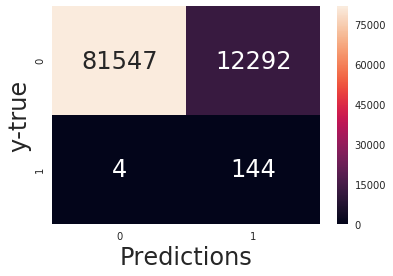

In [25]:
rf_cm = confusion_matrix(y_test, rf_preds)

sns.heatmap(rf_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [26]:
rf_cr = classification_report(y_test, rf_preds)
print('Random Forest Classifier classificaction report' '\n', rf_cr)

Random Forest Classifier classificaction report
               precision    recall  f1-score   support

           0       1.00      0.87      0.93     93839
           1       0.01      0.97      0.02       148

    accuracy                           0.87     93987
   macro avg       0.51      0.92      0.48     93987
weighted avg       1.00      0.87      0.93     93987



In [27]:
rf_us_metrics = {'Precision' : precision_score(y_test, rf_preds), 'Recall' : recall_score(y_test, rf_preds),
                  'F1 Score' : f1_score(y_test, rf_preds)}
print(rf_us_metrics)

{'Precision': 0.011579285944033452, 'Recall': 0.972972972972973, 'F1 Score': 0.022886204704386525}


### Decision Tree Classifier on under-sampled data

In [28]:
dtree = DecisionTreeClassifier()

dtree_grid = {'max_depth' : [None, 5, 6, 7], 'min_samples_split' : [6, 7, 8], 'min_samples_leaf' : [1, 2]}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

dtree_gs = GridSearchCV(estimator=dtree, param_grid=dtree_grid, cv=5)

dtree_gs.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 6, 7],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [6, 7, 8]})

In [29]:
dtree_gs.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8}

In [30]:
dtree_clf = DecisionTreeClassifier(**dtree_gs.best_params_)
dtree_clf.fit(X_train_us, y_train_us)

DecisionTreeClassifier(max_depth=6, min_samples_split=8)

In [31]:
dtree_preds = dtree_clf.predict(X_test)

Text(33.0, 0.5, 'y-true')

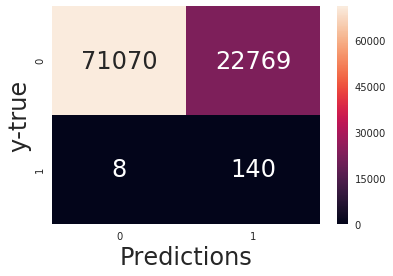

In [32]:
dtree_cm = confusion_matrix(y_test, dtree_preds)

sns.heatmap(dtree_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [33]:
dtree_cr = classification_report(y_test, dtree_preds)
print('Decision Tree Classifier classificaction report' '\n', rf_cr)

Decision Tree Classifier classificaction report
               precision    recall  f1-score   support

           0       1.00      0.87      0.93     93839
           1       0.01      0.97      0.02       148

    accuracy                           0.87     93987
   macro avg       0.51      0.92      0.48     93987
weighted avg       1.00      0.87      0.93     93987



In [34]:
dtree_us_metrics = {'Precision' : precision_score(y_test, dtree_preds), 'Recall' : recall_score(y_test, dtree_preds),
                  'F1 Score' : f1_score(y_test, dtree_preds)}
print(dtree_us_metrics)

{'Precision': 0.00611113536164826, 'Recall': 0.9459459459459459, 'F1 Score': 0.012143817495771347}


## It looks like undersampling method has failed to produce a remarkable model. This is not a surprise anyway. 

# Next, let's try over-sampling

In [35]:
# Over sampling the training set only

ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_sample(X_train, y_train)

In [36]:
print('Original training dataset class counts {}'.format(Counter(y_train)))
print('Over sampled dataset class counts {}'.format(Counter(y_train_os)))

Original training dataset class counts Counter({0: 190476, 1: 344})
Over sampled dataset class counts Counter({0: 190476, 1: 190476})


### Ada Boost Classifier on oversampled dataset

In [37]:
abc = AdaBoostClassifier()

abc_param = {'n_estimators' : [1000, 1500, 2000], 'learning_rate' : [1.0]}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

abc_gs = GridSearchCV(abc, param_grid=abc_param, cv=5)

abc_gs.fit(X_train_os, y_train_os)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [1.0],
                         'n_estimators': [1000, 1500, 2000]})

In [38]:
print(abc_gs.best_params_)

{'learning_rate': 1.0, 'n_estimators': 2000}


In [39]:
adaboost = AdaBoostClassifier(**abc_gs.best_params_)

adaboost.fit(X_train_os, y_train_os)

AdaBoostClassifier(n_estimators=2000)

In [40]:
ada_preds = adaboost.predict(X_test)

Text(33.0, 0.5, 'y-true')

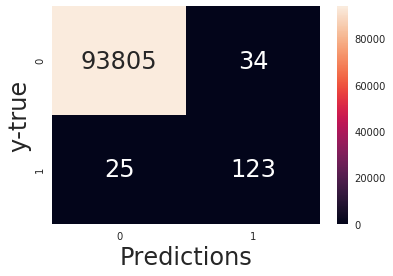

In [41]:
ada_cm = confusion_matrix(y_test, ada_preds)

sns.heatmap(ada_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [42]:
ada_cr = classification_report(y_test, ada_preds)
print('AdaBoostClassifier classification report' '\n', ada_cr)

AdaBoostClassifier classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93839
           1       0.78      0.83      0.81       148

    accuracy                           1.00     93987
   macro avg       0.89      0.92      0.90     93987
weighted avg       1.00      1.00      1.00     93987



In [43]:
ada_os_metrics = {'Precision' : precision_score(y_test, ada_preds), 'Recall' : recall_score(y_test, ada_preds),
                  'F1 Score' : f1_score(y_test, ada_preds)}
print(ada_os_metrics)

{'Precision': 0.7834394904458599, 'Recall': 0.831081081081081, 'F1 Score': 0.8065573770491803}


### Random Forest Classifier on oversampled dataset

In [44]:
rf = RandomForestClassifier()

rf_param = {'n_estimators' : [200, 300, 400, 500, 1000, 2000, 3000], 'max_depth' : [30], 
            'min_samples_split' : [30], 'max_features' : ['log2']}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

rf_gs = GridSearchCV(estimator=rf, param_grid=rf_param, cv=5, n_jobs=-2)

rf_gs.fit(X_train_os, y_train_os)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'max_depth': [30], 'max_features': ['log2'],
                         'min_samples_split': [30],
                         'n_estimators': [200, 300, 400, 500, 1000, 2000,
                                          3000]})

In [45]:
rf_gs.best_params_

{'max_depth': 30,
 'max_features': 'log2',
 'min_samples_split': 30,
 'n_estimators': 300}

In [46]:
rf_clf = RandomForestClassifier(**rf_gs.best_params_)

rf_clf.fit(X_train_os, y_train_os)

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=30,
                       n_estimators=300)

In [47]:
rf_preds = rf_clf.predict(X_test)

Text(33.0, 0.5, 'y-true')

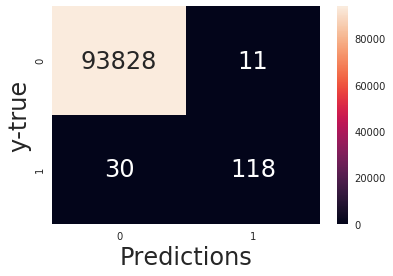

In [48]:
rf_cm = confusion_matrix(y_test, rf_preds)

sns.heatmap(rf_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [49]:
rf_cr = classification_report(y_test, rf_preds)
print('Random Forest Classifier classificaction report' '\n', rf_cr)

Random Forest Classifier classificaction report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93839
           1       0.91      0.80      0.85       148

    accuracy                           1.00     93987
   macro avg       0.96      0.90      0.93     93987
weighted avg       1.00      1.00      1.00     93987



In [50]:
rf_os_metrics = {'Precision' : precision_score(y_test, rf_preds), 'Recall' : recall_score(y_test, rf_preds),
                  'F1 Score' : f1_score(y_test, rf_preds)}
print(rf_os_metrics)

{'Precision': 0.9147286821705426, 'Recall': 0.7972972972972973, 'F1 Score': 0.8519855595667869}


### Decision Tree Classifier on oversampled dataset

In [51]:
dtree = DecisionTreeClassifier()

dtree_grid = {'splitter' : ['best'], 'max_depth' : [None],
              'min_samples_split' : [7], 'min_samples_leaf' : [1]}
# Why am I using this parameter grid with these particular values? 
# I have run grid search several times on this dataset before, 
# in order to save resources and time, I am using the relevant values only

dtree_gs = GridSearchCV(estimator=dtree, param_grid=dtree_grid, cv=5)

dtree_gs.fit(X_train_os, y_train_os)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [7], 'splitter': ['best']})

In [52]:
dtree_gs.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'splitter': 'best'}

In [53]:
dtree_clf = DecisionTreeClassifier(**dtree_gs.best_params_)
dtree_clf.fit(X_train_os, y_train_os)

DecisionTreeClassifier(min_samples_split=7)

In [54]:
dtree_preds = dtree_clf.predict(X_test)

Text(33.0, 0.5, 'y-true')

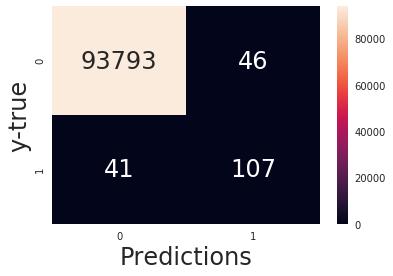

In [55]:
dtree_cm = confusion_matrix(y_test, dtree_preds)

sns.heatmap(dtree_cm, annot=True, annot_kws={'size' : 24}, fmt='g')
plt.xlabel('Predictions', size=24)
plt.ylabel('y-true', size=24)

In [56]:
dtree_cr = classification_report(y_test, dtree_preds)
print('Decision Tree Classifier classificaction report' '\n', rf_cr)

Decision Tree Classifier classificaction report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93839
           1       0.91      0.80      0.85       148

    accuracy                           1.00     93987
   macro avg       0.96      0.90      0.93     93987
weighted avg       1.00      1.00      1.00     93987



In [57]:
dtree_os_metrics = {'Precision' : precision_score(y_test, dtree_preds), 'Recall' : recall_score(y_test, dtree_preds),
                  'F1 Score' : f1_score(y_test, dtree_preds)}
print(ada_os_metrics)

{'Precision': 0.7834394904458599, 'Recall': 0.831081081081081, 'F1 Score': 0.8065573770491803}


In [58]:
all_metrics = [ada_us_metrics, rf_us_metrics, dtree_us_metrics, ada_os_metrics, rf_os_metrics, ada_os_metrics]
print(all_metrics)

[{'Precision': 0.0038687794795696645, 'Recall': 0.9864864864864865, 'F1 Score': 0.007707332523887452}, {'Precision': 0.011579285944033452, 'Recall': 0.972972972972973, 'F1 Score': 0.022886204704386525}, {'Precision': 0.00611113536164826, 'Recall': 0.9459459459459459, 'F1 Score': 0.012143817495771347}, {'Precision': 0.7834394904458599, 'Recall': 0.831081081081081, 'F1 Score': 0.8065573770491803}, {'Precision': 0.9147286821705426, 'Recall': 0.7972972972972973, 'F1 Score': 0.8519855595667869}, {'Precision': 0.7834394904458599, 'Recall': 0.831081081081081, 'F1 Score': 0.8065573770491803}]


In [59]:
mdf = pd.DataFrame(all_metrics, index= ['ada_under_samp', 'rf_under_samp', 'dtree_undersamp', 
                                        'ada_over_samp', 'rf_over_samp', 'ada_over_samp'])
mdf

,F1 Score,Precision,Recall
ada_under_samp,0.007707,0.003869,0.986486
rf_under_samp,0.022886,0.011579,0.972973
dtree_undersamp,0.012144,0.006111,0.945946
ada_over_samp,0.806557,0.783439,0.831081
rf_over_samp,0.851986,0.914729,0.797297
ada_over_samp,0.806557,0.783439,0.831081


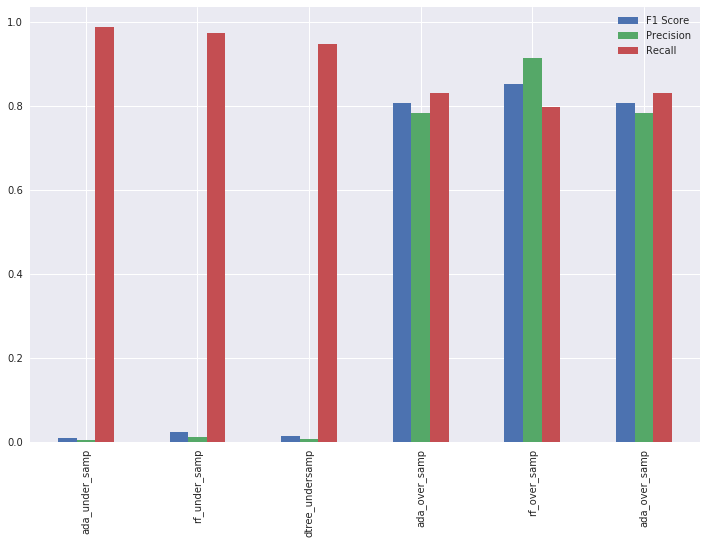

In [60]:
mdf.plot(kind='bar', figsize=(12, 8))

# Conclusion
### While the under-sampling technique resulted in slightly better true positives (TP), and thus better recall rates, the number of false positives (FP) was too high. This resulted in a poor precision rate. Also, in a real world scenario, this would cause customer dissatisfaction and a huge number of calls to the customer services department. Not good!
### The over-sampling technique has significantly improved the precision score, thanks to few false positives (FP), while pretty much maintaining the recall 
## Happy days